# Modeling

- Overview Here

## Model Evaluation

- TBD

In [1]:
# Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd

# Set style
plt.style.use('seaborn')

In [2]:
# Import util file

from util import dickey_fuller, process_neighborhood, report_metrics

In [36]:
# Modeling

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest

from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [4]:
# Import clean dataset

df = pd.read_csv('./clean_data/final_clean_ridership.csv', low_memory=False)

In [5]:
# Convert starttime to date and set as index

df['starttime'] = pd.to_datetime(df['starttime'])

df.set_index('starttime', inplace=True)

In [6]:
df.head()

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2013-06-01,72,40.767272,-73.993929,40,2013,Clinton,Manhattan
2013-06-01,79,40.719116,-74.006667,61,2013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
2013-06-01,82,40.711174,-74.000165,6,2013,Chinatown,Manhattan
2013-06-01,83,40.683826,-73.976323,32,2013,Fort Greene,Brooklyn
2013-06-01,116,40.741776,-74.001497,53,2013,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan


In [7]:
# Create the daily file

daily_ridership = df[['ride_count']].resample('1D').sum()

# Filter for only data prior to 5/1/2021 (logic for this is in the EDA notebook)
daily_ridership = daily_ridership[daily_ridership.index < '2021-06-01']

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

## Naive Baseline

- Take average of the train data to predict the test
- Fit a simple linear regression
- The testing data will be from June 1st 2020 to June 1st 2021. This is to ensure that when I bring exogenous variables in down the line that the training data has some period from COVID to train on.

### Average of Train Period

In [8]:
# Inserting a time period track for our naive models

daily_ridership.insert(0, 't', range(len(daily_ridership)))

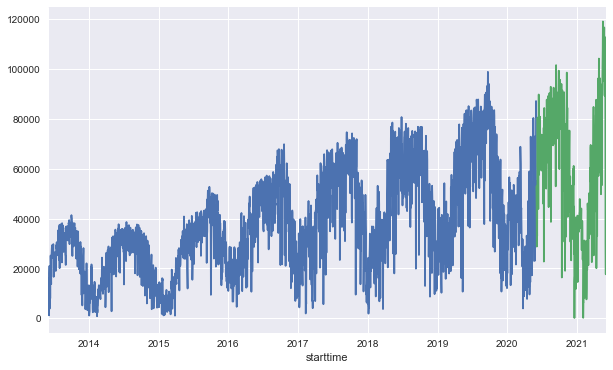

In [9]:
# Define bounds of train / test

daily_ridership['future'] = (daily_ridership.index > '2020-05-31').astype('int')

# Now plot
plt.figure(figsize=(10,6))
daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot()
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot()
plt.show();

In [10]:
# Creating train test splits for our naive models

X_train = daily_ridership.loc[daily_ridership.future == 0, 't'].values.reshape(-1, 1)
X_test = daily_ridership.loc[daily_ridership.future == 1, 't'].values.reshape(-1, 1)
# Our train set is our actual value in the series
y_train = daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].values
y_test = daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].values

In [11]:
# Naive baseline prediction, will take the average of the train data

y_preds = daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].mean()

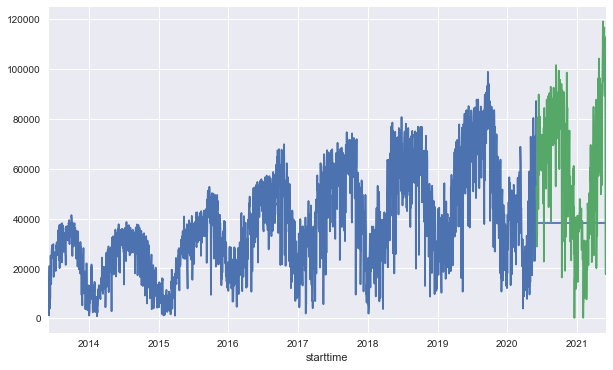

In [12]:
# Plot the baseline prediction

plt.figure(figsize=(10,6))
daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot()
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot()

# Predictions go here
plt.hlines(y=y_preds,
          xmin=daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].index[0],
          xmax=daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].index[-1])


plt.show();

In [13]:
# Show results of first naive model

y_preds = [y_preds] * len(y_test)

results = report_metrics(y_test, y_preds, True)

Explained Variance: 0.0000
MAE: 27,515
RMSE: 33,183
r^2: -0.7809


### Simple linear regression

In [14]:
# Fit the linear model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)
y_trend_lr = lr.predict(X_train)

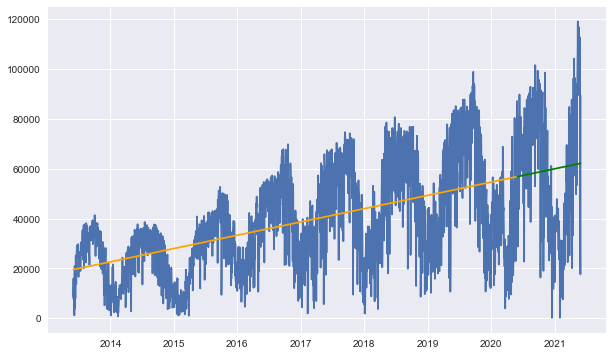

In [15]:
# Plot results

plt.figure(figsize=(10,6))
plt.plot(daily_ridership['ride_count'])
plt.plot(daily_ridership.loc[daily_ridership.future == 0].index, y_trend_lr, color='orange')
plt.plot(daily_ridership.loc[daily_ridership.future == 1].index, y_preds_lr, color='green')
plt.show()

In [16]:
# Evaluate linear regression

results = report_metrics(y_test, y_preds_lr, True)

Explained Variance: -0.0224
MAE: 21,578
RMSE: 25,152
r^2: -0.0232


### Naive Model Takeaways

- These models obviously don't perform paticularly well, but gives us a baseline to compare subsequent models against

## First Arima model

### Modeling EDA

- ACF and PACF plot
- Test correlations of different lags

In [17]:
# Add lags for 7 days, one month, and one year to test correlation

daily_ridership['lag7'] = daily_ridership['ride_count'].shift(7)
daily_ridership['lag30'] = daily_ridership['ride_count'].shift(30)
daily_ridership['lag365'] = daily_ridership['ride_count'].shift(365)

# Drop t and future used in Naive model
daily_ridership = daily_ridership.drop(labels=['t'], axis=1)

daily_ridership.corr()

,ride_count,future,lag7,lag30,lag365
ride_count,1.000000,0.331278,0.790319,0.650998,0.662452
future,0.331278,1.000000,0.331122,0.293798,0.292404
lag7,0.790319,0.331122,1.000000,0.681190,0.653853
lag30,0.650998,0.293798,0.681190,1.000000,0.603883
lag365,0.662452,0.292404,0.653853,0.603883,1.000000


Interestingly, the 1 year lag isn't as strongly correlated as I thought. Maybe it's because the mean is constantly increasing. The 7 day lag is reasonably well correlated, suggesting that there is a weekly trend to the data (i.e., more people use the bikes on weekdays to commute).

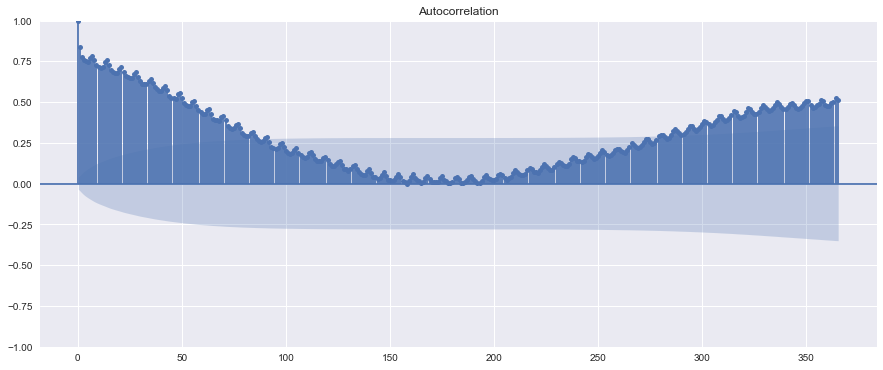

In [18]:
# In the ACF plot, you can clearly see the yearly seasonality in this data
# Less obvious (because of the scale) is the weekly trend as well

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_acf(daily_ridership['ride_count'], lags=365, ax=ax);

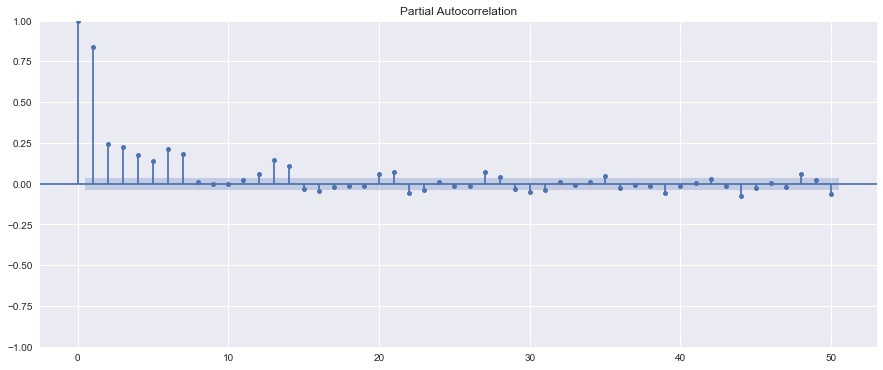

In [19]:
# In the PACF plot, you see more of the weekly trend instead of the seasonal trend

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_pacf(daily_ridership['ride_count'], method='ywm', lags=50, ax=ax);

In [20]:
# Arima model

# Drop lag columns

daily_ridership.drop(labels=['lag7', 'lag30', 'lag365'], axis=1, inplace=True)

In [21]:
daily_ridership.head()

,ride_count,future
starttime,,
2013-06-01,8722,0
2013-06-02,15971,0
2013-06-03,7598,0
2013-06-04,15782,0
2013-06-05,15690,0


In [166]:
# Fit an ARIMA model
# Choosing 8 for the AR term given the PACF plot previous
# Just using 1 for D and Q until I run a grid search.

arima_order = (8, 1, 1)
arima = ARIMA(daily_ridership.loc[daily_ridership.future == 0]['ride_count'], 
                  order=arima_order)
baseline_arima = arima.fit()

In [168]:
# Create predictions based on the model and store it in a new dataframe

daily_future_df = daily_ridership.loc[daily_ridership.future == 1].copy()
daily_future_df['arima_preds'] = baseline_arima.forecast(steps = len(y_test))

# Print metric summary

results = report_metrics(future_df['ride_count'], daily_future_df['arima_preds'], True)

Explained Variance: 0.0025
MAE: 21,060
RMSE: 24,834
r^2: 0.0025


Haven't improved on the baseline model all that much. Will definitely need to fit a seasonal component.

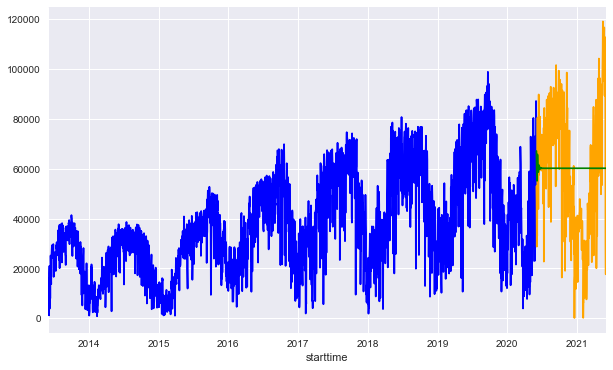

In [171]:
# Plot the first ARIMA model output

fig, ax = plt.subplots(figsize=(10,6))

daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot(color='blue', label='actual train', ax=ax)
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot(color='orange', label='actual test', ax=ax)
daily_future_df['arima_preds'].plot(color='green', label='predicted test', ax=ax);

## First SARIMA model

I clearly need to capture the yearly seasonal component in the data

In [153]:
seas_arima = ARIMA(daily_ridership.loc[daily_ridership.future == 0]['ride_count'], 
                   order = (2, 1, 1), seasonal_order=(0, 0, 0, 365))

baseline_sarima = seas_arima.fit()

In [154]:
# Create predictions based on the model and store it in a new dataframe

daily_future_df = daily_ridership.loc[daily_ridership.future == 1].copy()
daily_future_df['preds'] = baseline_sarima.forecast(steps = len(y_test))

# Print metric summary

results = report_metrics(daily_future_df['ride_count'], daily_future_df['preds_sarima'], True)

Explained Variance: -0.0003
MAE: 21,200
RMSE: 24,895
r^2: -0.0024


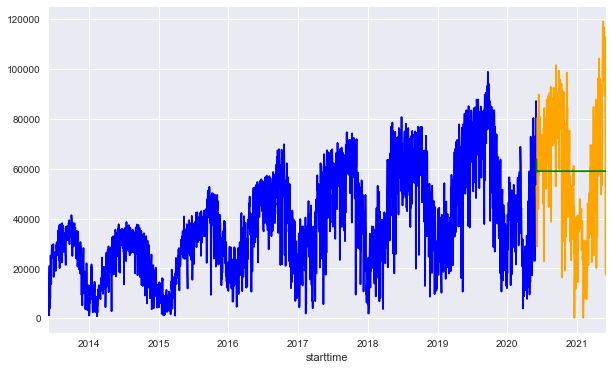

In [155]:
fig, ax = plt.subplots(figsize=(10,6))

daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot(color='blue', label='actual train', ax=ax)
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot(color='orange', label='actual test', ax=ax)
future_df['preds'].plot(color='green', label='predicted test', ax=ax);

Try removing the yearly seasonal trend and just focus on the weekly trend

In [173]:
# Isolate the seasonal component and divide ridership by this amount

decomposed_ts = decompose(daily_ridership['ride_count'].values, 'multiplicative', m=365)

seasonal = decomposed_ts.seasonal

daily_ridership['seas_removed'] = daily_ridership['ride_count'] / seasonal

daily_ridership['seas_removed_log'] = daily_ridership['seas_removed'].apply(lambda x: np.log(x))

In [176]:
daily_ridership[daily_ridership['future'] == 1]['seas_removed_log']

,ride_count,future,seas_removed,seas_removed_log
starttime,,,,
2020-06-01,52926,1,40486.183345,10.608716
2020-06-02,46471,1,36012.385442,10.491618
2020-06-03,28766,1,23797.371014,10.077330
2020-06-04,39659,1,36854.105538,10.514722
2020-06-05,33064,1,28244.782621,10.248664
...,...,...,...,...
2021-05-27,112605,1,102017.344765,11.532898
2021-05-28,62797,1,54620.932953,10.908172
2021-05-29,30059,1,27701.685311,10.229249


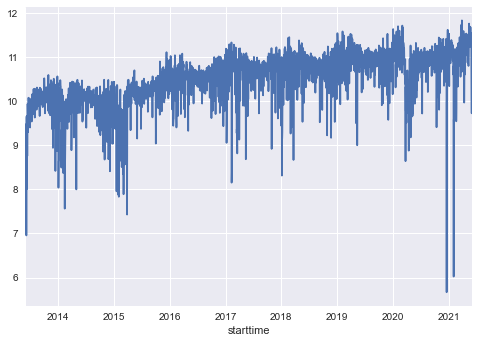

In [174]:
daily_ridership['seas_removed_log'].plot();

In [162]:
daily_ridership.shape

(2922, 2)

In [ ]:
seas_arima = ARIMA(daily_ridership.loc[daily_ridership[daily_ridership['future'] == 0]['seas_removed_log'], 
                   order = (1, 1, 1), seasonal_order=(0, 0, 0, 365))

### SARIMAX

We're still not getting the seasonality component correct
- Next step is to try to fit a SARIMAX model (minus the exogenous variables for now)
- If that doesn't work, will resample for the 7 day average to see if we can eliminate the weekly trend (and performance improve performance)

In [39]:
train = daily_ridership[daily_ridership['future'] == 0]['ride_count']
test = daily_ridership[daily_ridership['future'] == 1]['ride_count']

In [42]:
# Test to see if we should difference the data
# It's close, but for this pass I will not 
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(daily_ridership['ride_count'])  # (0.01, False)

print(f"P-Value: {p_val}, so should you difference the data? {should_diff}")

P-Value: 0.03974137753953091, so should you difference the data? False


In [46]:
# Grid search p, d, q parameters

arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, m=7) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=55025.782, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=54692.599, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=54371.669, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=55023.797, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=54428.220, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=54335.899, Time=0.95 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.26 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=54965.938, Time=0.43 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=54179.103, Time=1.26 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=54198.665, Time=0.43 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.72 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=54688.2

In [48]:
sari_mod  = SARIMAX(train, order=(2, 1, 2), seasonal_order=(0, 0, 2, 7)).fit()

/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [58]:
sari_mod.forecast(steps=len(y_test))

2020-06-01    64850.835892
2020-06-02    59440.603447
2020-06-03    58082.114955
2020-06-04    57238.099083
2020-06-05    57273.427089
                  ...     
2021-05-27    59011.677187
2021-05-28    59011.677188
2021-05-29    59011.677187
2021-05-30    59011.677188
2021-05-31    59011.677187
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [49]:
# Create predictions based on the model and store it in a new dataframe

future_df = daily_ridership.loc[daily_ridership.future == 1].copy()
future_df['preds'] = sari_mod.forecast(steps = len(y_test))

# Print metric summary

results = report_metrics(future_df['ride_count'], future_df['preds'], True)

Explained Variance: 0.0022
MAE: 21,163
RMSE: 24,863
r^2: 0.0002


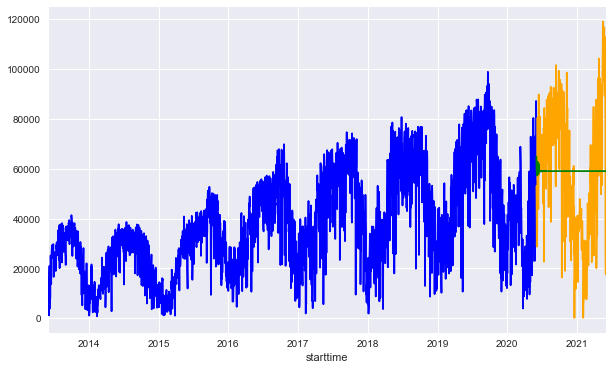

In [50]:
fig, ax = plt.subplots(figsize=(10,6))

daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot(color='blue', label='actual train', ax=ax)
# daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot(color='orange', label='actual test', ax=ax)
future_df['preds'].plot(color='green', label='predicted test', ax=ax);

Two options as follow-up
- Make data stationary before modeling (log transform)
- Resample the data to weekly

In [54]:
test.head()

,ride_count,future,ride_log
starttime,,,
2013-06-01,8722,0,9.073604
2013-06-02,15971,0,9.678530
2013-06-03,7598,0,8.935640
2013-06-04,15782,0,9.666625
2013-06-05,15690,0,9.660779


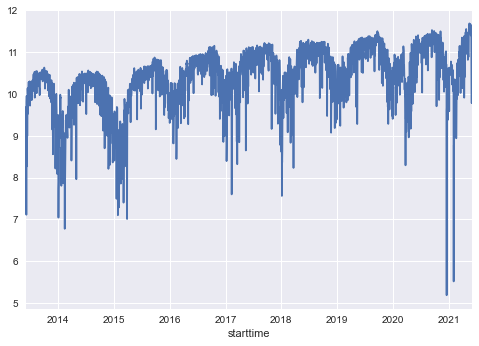

In [55]:
test['ride_log'].plot();

### Weekly Ridership

In [61]:
weekly_ridership = daily_ridership.resample('W-MON').sum().drop('future', axis=1)

In [77]:
# RUn dickey fuller on unadjusted data

dickey_fuller(weekly_ridership['ride_count'], False, True)

# This is actually showing us that it's stationary

Data is stationary. P-value of 0.0031


(True, 0.003060372665617202)

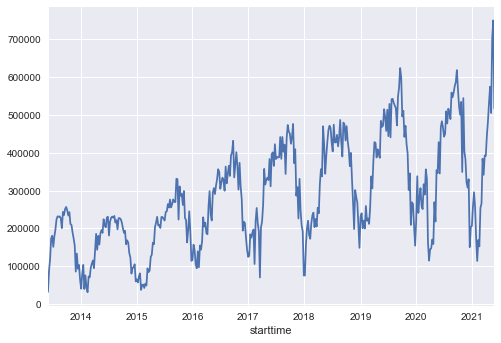

In [63]:
weekly_ridership['ride_count'].plot();

In [64]:
# Create future time stampe

weekly_ridership['future'] = (weekly_ridership.index > '2020-05-31').astype('int')

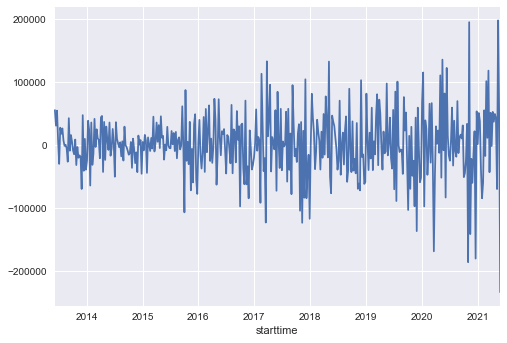

In [69]:
# Plot the 1d diff

weekly_ridership['1d_diff'] = weekly_ridership['ride_count'].diff()

weekly_ridership['1d_diff'].plot();

# There is increasing variance still, so we may want to log transform the series

In [78]:
weekly_ridership['ride_count_log'] = weekly_ridership['ride_count'].apply(lambda x: np.log(x))

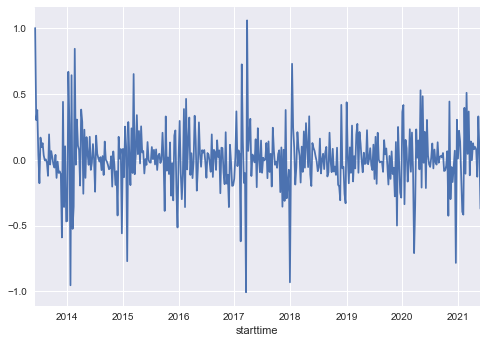

In [80]:
weekly_ridership['ride_count_log'].diff().plot();

In [99]:
train_weekly = weekly_ridership[weekly_ridership['future'] == 0]['ride_count_log']
test_weekly = weekly_ridership[weekly_ridership['future'] == 1]['ride_count_log']

In [118]:
sari_mod_weekly  = SARIMAX(train_weekly, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()

In [119]:
future_df = weekly_ridership.loc[weekly_ridership.future == 1].copy()
future_df['preds'] = sari_mod_weekly.forecast(steps = len(test_weekly))

In [120]:
results = report_metrics(test_weekly, future_df['preds'], True)

Explained Variance: 0.3717
MAE: 1
RMSE: 1
r^2: -1.2386


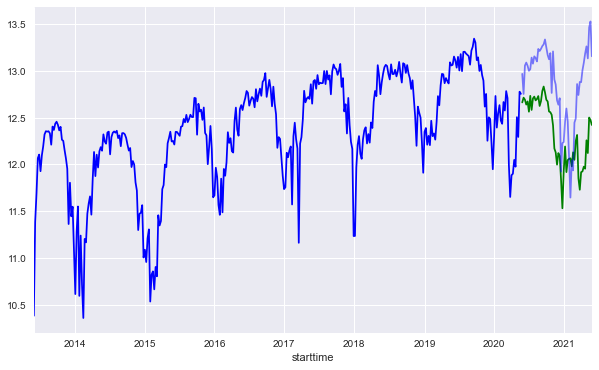

In [122]:
fig, ax = plt.subplots(figsize=(10,6))

weekly_ridership.loc[weekly_ridership.future == 0, 'ride_count_log'].plot(color='blue', label='actual train', ax=ax)
# daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot(color='orange', label='actual test', ax=ax)
future_df['preds'].plot(color='green', label='predicted test', ax=ax)
weekly_ridership.loc[weekly_ridership.future == 1, 'ride_count_log'].plot(color='blue', label='actual train', ax=ax, alpha=0.5);

Adjust the train period to not include COVID

In [130]:
weekly_ridership.drop('future', axis=1, inplace=True)

weekly_ridership['future'] = (weekly_ridership.index > '2020-03-01').astype('int')

In [131]:
train_weekly2 = weekly_ridership[weekly_ridership['future'] == 0]['ride_count_log']
test_weekly2 = weekly_ridership[weekly_ridership['future'] == 1]['ride_count_log']

In [132]:
sari_mod_weekly2  = SARIMAX(train_weekly2, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()

In [133]:
future_df = weekly_ridership.loc[weekly_ridership.future == 1].copy()
future_df['preds'] = sari_mod_weekly2.forecast(steps = len(test_weekly2))

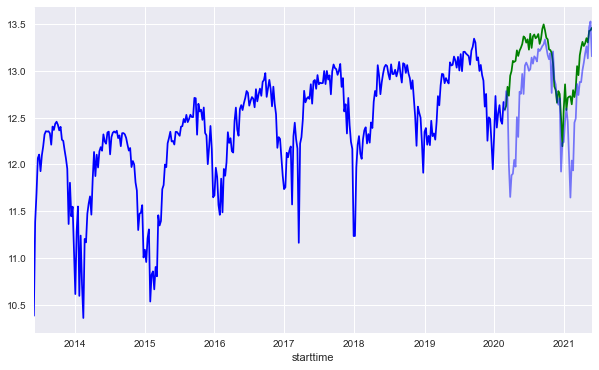

In [134]:
fig, ax = plt.subplots(figsize=(10,6))

weekly_ridership.loc[weekly_ridership.future == 0, 'ride_count_log'].plot(color='blue', label='actual train', ax=ax)
# daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot(color='orange', label='actual test', ax=ax)
future_df['preds'].plot(color='green', label='predicted test', ax=ax)
weekly_ridership.loc[weekly_ridership.future == 1, 'ride_count_log'].plot(color='blue', label='actual train', ax=ax, alpha=0.5);

In [135]:
results2 = report_metrics(test_weekly2, future_df['preds'], True)

Explained Variance: 0.4797
MAE: 0
RMSE: 0
r^2: 0.0135


## Test performance when training on data through 2018 and testing on 2019
- This will be a proxy for a more normalized environment

In [143]:
weekly_ridership2.head()

,ride_count,future,ride_count_log
starttime,,,
2013-06-03,32291,0,10.382544
2013-06-10,88056,0,11.385728
2013-06-17,119152,0,11.688155
2013-06-24,174063,0,12.067173
2013-07-01,180791,0,12.105097


In [144]:
weekly_ridership2 = daily_ridership.resample('W-MON').sum().drop('future', axis=1)

weekly_ridership2['future'] = (weekly_ridership2.index > '2018-12-31').astype('int')

weekly_ridership2['ride_count_log'] = weekly_ridership2['ride_count'].apply(lambda x: np.log(x))

weekly_ridership2 = weekly_ridership2[weekly_ridership2.index < '2020-03-01']

In [145]:
train_weekly3 = weekly_ridership2[weekly_ridership2['future'] == 0]['ride_count_log']
test_weekly3 = weekly_ridership2[weekly_ridership2['future'] == 1]['ride_count_log']

In [146]:
sari_mod_weekly2  = SARIMAX(train_weekly3, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52)).fit()

In [147]:
future_df = weekly_ridership2.loc[weekly_ridership2.future == 1].copy()
future_df['preds'] = sari_mod_weekly2.forecast(steps = len(test_weekly3))

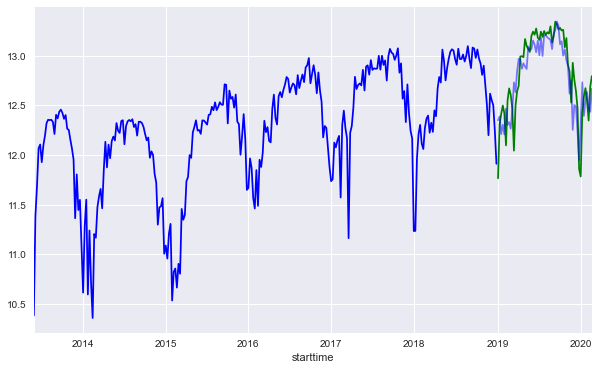

In [148]:
fig, ax = plt.subplots(figsize=(10,6))

weekly_ridership2.loc[weekly_ridership2.future == 0, 'ride_count_log'].plot(color='blue', label='actual train', ax=ax)
# daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot(color='orange', label='actual test', ax=ax)
future_df['preds'].plot(color='green', label='predicted test', ax=ax)
weekly_ridership2.loc[weekly_ridership2.future == 1, 'ride_count_log'].plot(color='blue', label='actual train', ax=ax, alpha=0.5);

In [149]:
results3 = report_metrics(test_weekly3, future_df['preds'], True)

Explained Variance: 0.5941
MAE: 0
RMSE: 0
r^2: 0.5756
